In [ ]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/data-set2/data_2', transform=transform)
print(len(full_dataset))

1200


In [4]:
test_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
resnet = models.resnet18(pretrained=False)

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
device

device(type='cpu')

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [10]:
epochs = 10

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Test loop
    resnet.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%')

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Loss: 2.931692910194397
Test Loss: 2.8256620168685913, Accuracy: 12.5%
Epoch 2/10, Loss: 2.6810329437255858
Test Loss: 2.627194792032242, Accuracy: 17.916666666666668%
Epoch 3/10, Loss: 2.5523648500442504
Test Loss: 2.5590154826641083, Accuracy: 22.083333333333332%
Epoch 4/10, Loss: 2.460423405965169
Test Loss: 2.4298754930496216, Accuracy: 27.083333333333332%
Epoch 5/10, Loss: 2.3901973644892376
Test Loss: 2.4508582949638367, Accuracy: 24.166666666666668%
Epoch 6/10, Loss: 2.3154184738794963
Test Loss: 2.318271666765213, Accuracy: 32.916666666666664%
Epoch 7/10, Loss: 2.2530537883440656
Test Loss: 2.3212413787841797, Accuracy: 32.083333333333336%
Epoch 8/10, Loss: 2.2253561496734617
Test Loss: 2.2900982201099396, Accuracy: 29.583333333333332%
Epoch 9/10, Loss: 2.1126328229904177
Test Loss: 2.2373151779174805, Accuracy: 33.75%
Epoch 10/10, Loss: 2.07834400733312
Test Loss: 2.1720531582832336, Accuracy: 37.083333333333336%


Analysis

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


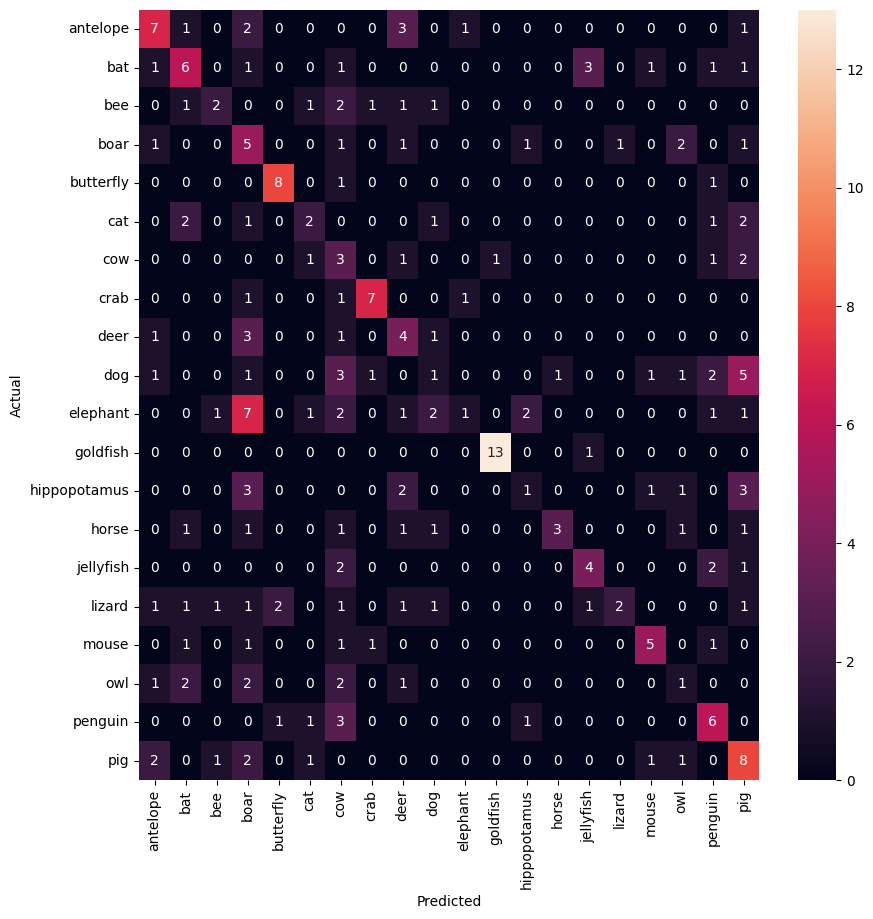

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, preds = torch.max(outputs, 1)
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=test_dataset.dataset.classes,
            yticklabels=test_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

resnet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)

print(class_report)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

    antelope       0.47      0.47      0.47        15
         bat       0.40      0.40      0.40        15
         bee       0.40      0.22      0.29         9
        boar       0.16      0.38      0.23        13
   butterfly       0.73      0.80      0.76        10
         cat       0.29      0.22      0.25         9
         cow       0.12      0.33      0.18         9
        crab       0.70      0.70      0.70        10
        deer       0.25      0.40      0.31        10
         dog       0.12      0.06      0.08        17
    elephant       0.33      0.05      0.09        19
    goldfish       0.93      0.93      0.93        14
hippopotamus       0.20      0.09      0.13        11
       horse       0.75      0.30      0.43        10
   jellyfish       0.44      0.44      0.44         9
      lizard       0.67      0.15      0.25        13
       mouse       0.56      0.50      0.53        10
         owl       0.14    